**Let's build a text generation model in Shakespeare's style.**
**I am using Google Colab for this project. You can use free GPU runtime in the notebook for free**

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow.keras.utils as ku 
import numpy as np 

**Download Shakespeare's Sonnets text file from Laurence Moroney's blogpost**

In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-07-15 08:51:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-07-15 08:51:29 (99.0 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



**Build a LSTM network with Keras Sequential Model**

In [0]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              322605    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,422,571
Trainable params: 6,422,571
Non-trainable params: 0
____________________________________________

In [0]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

W0715 07:23:05.761524 140268800075648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 54s 3ms/sample - loss: 6.9727 - acc: 0.0223
Epoch 2/100
15462/15462 [==============================] - 51s 3ms/sample - loss: 6.5141 - acc: 0.0219
Epoch 3/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 6.3871 - acc: 0.0260
Epoch 4/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 6.2632 - acc: 0.0337
Epoch 5/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 6.1550 - acc: 0.0391
Epoch 6/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 6.0463 - acc: 0.0416
Epoch 7/100
15462/15462 [==============================] - 51s 3ms/sample - loss: 5.9344 - acc: 0.0440
Epoch 8/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 5.8164 - acc: 0.0473
Epoch 9/100
15462/15462 [==============================] - 52s 3ms/sample - loss: 5.7002 - acc: 0.0558
Epoch 10/100
15462/15462 [==============================] - 52s 3ms/sampl

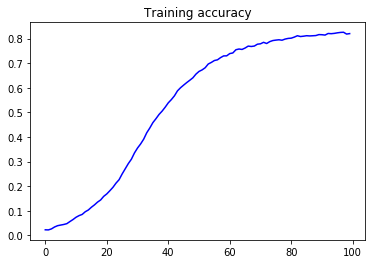

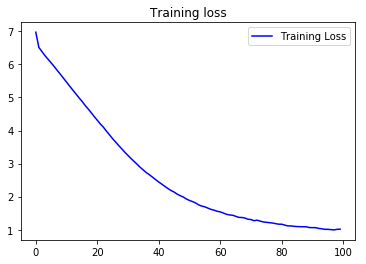

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Let's generate poem from a seed text in Shakespeare's style**

In [0]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope fair one one part doth show thee more must seem truth was on that beauty doth lie on thee in it must bear thee find me find away forget to be injury of age days state weeds leaves loss on thee none lived in ease doth truth before so view he give razed friend breast shines days days must days must wilt do your thine eyes seem so bright in thine friend torn taken still ' none fire find me was forth much so short it shines so deem'd seen such wrong night open wrong of rolling wrong or night
